In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import utils


## 导入数据

In [5]:
train_data = pd.read_csv(r'./dataset/train.csv')
test_data = pd.read_csv(r'./dataset/test.csv')


## 预处理数据

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# train_data.iloc[:, 1:-1] 选择所有行，第2~倒数第2列（因为左闭右开）
# test_data.iloc[:, 1:] 选择所有行，第2~最后一列
# pd.concat(...) 默认竖直拼接（axis=0）
# all_features为train和test的所有features，方便后续统一操作

print(all_features.shape)
print('---')
print(all_features.iloc[0:3, [0, 1, 2, 3, -3, -2, -1]])
# 打印前4行、前4和后3列

(2919, 79)
---
   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal


In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# all_features.dtypes 返回 列名:dtype，类型为Series
# all_features.dtypes != 'object' 返回 列名:True/False，类型为Series
# all_features.dtypes[all_features.dtypes != 'object'] 选择不是object（为数值）的列的子集，列名:dtype，类型为Series
# Series.index 得到列名

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# all_features[numeric_features] 取出数值列
# .apply(...) 默认按列应用括号中的函数（axis=0）
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
# lambda为匿名函数，格式为 lambda 参数: 表达式

all_features[numeric_features] = all_features[numeric_features].fillna(0)
# 用均值填充na，而标准化后均值为0，故 .fillna(0)


In [8]:
all_features = pd.get_dummies(all_features, dummy_na=True)
# pd.get_dummies() 把类型为object的列拆成一组独热码
# dummy_na=True 表示object列中的na也生成独热码中的一列

print(all_features.shape)
# all_features从(2919, 79)变为(2919, 330)，即拆分后列数增加


(2919, 330)


In [9]:
n_train = train_data.shape[0]
# n_train表示 train data的个数（行数）

train_features = torch.tensor(all_features[:n_train].to_numpy(dtype='float32'), dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].to_numpy(dtype='float32'), dtype=torch.float)
# 从合并的all_features中分离出train_features和test_features
# 由于all_features中仍有多种类型（bool和float），而to_numpy()会返回object数组导致报错，因此先转为float的numpy，再转为float的tensor

train_labels = torch.tensor(train_data.SalePrice.to_numpy(), dtype=torch.float).view(-1, 1)
# train_data.SalePrice 从train_data（类型未DataFrame）中取出SalePrice列
# 将SalePrice列作为labels，转化为tensor


## 训练模型

In [10]:
loss = torch.nn.MSELoss()
# 定义train时的loss为均方误差，即各个参数作差平方的平均的开根号

def get_net(feature_num):
    # 定义网络模型

    net = nn.Linear(feature_num, 1)
    # 定义线性模型，行数为输入features数，列数为输出类型数

    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    # net.parameters() 遍历网络里所有可学习参数，包括权重和偏移
    # nn.init.normal_ 用正态分布N(0,0.01)给每个参数初始化

    return net


In [11]:
def log_rmse(net, features, labels):
    # 定义test时用对数均方根误差

    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        # net(features) 得到net预测的结果
        # torch.max() 将预测结果中小于1的数置为1，取log时更稳定

        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
        # 定义对数均方根误差，即用对数做均方误差的计算

    return rmse.item()


In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 训练模型，返回train、test的log‑RMSE列表

    train_ls, test_ls = [], []
    # 用列表记录每个epoch的训练、测试的log‑RMSE

    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    # 把特征和标签打包成数据集对象

    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 创建小批量迭代器，并打乱数据

    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # 定义优化器（Adam），并设置lr和weight_decay

    net = net.float()
    # 确保模型参数是float类型

    for epoch in range(num_epochs):
        # 遍历num_epochs个阶段

        for X, y in train_iter:
            # 从迭代器中取出batch

            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        train_ls.append(log_rmse(net, train_features, train_labels))
        # 每个epoch结束后，计算并记录训练集的log‑RMSE

        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        # 如果有测试集标签，就计算验证集的log‑RMSE

    return train_ls, test_ls


## K折交叉验证

In [13]:
def get_k_fold_data(k, i, X, y):
    # 返回第i个fold交叉验证时所需要的训练、验证数据

    assert k > 1
    # 检查k>1是否成立但不改变k的值，成立则程序继续，不成立则抛出AssertionError

    fold_size = X.shape[0] // k
    # 每个fold的大小为总数除以fold数

    X_train, y_train = None, None

    for j in range(k):
        # 遍历每个fold

        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 创建第j个fold的索引切片

        X_part, y_part = X[idx, :], y[idx]
        # 选取第j个fold的数据X_part和标签y_part
        # X_part和y_part都按idx选择行，其中X_part选择所有列

        if j == i:
            X_valid, y_valid = X_part, y_part
            # X_valid, y_valid 为返回的验证集数据

        elif X_train is None:
            X_train, y_train = X_part, y_part
            # 如果这是第一个fold，用于将训练集数据初始化
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
            # 如果训练集数据已完成初始化，竖直拼接

    return X_train, y_train, X_valid, y_valid



In [14]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    # k折交叉验证，返回train、test中的平均误差

    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        # 遍历每个fold

        data = get_k_fold_data(k, i, X_train, y_train)
        # 返回第k个训练数据、验证数据

        net = get_net(X_train.shape[1])
        # 定义网络

        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        # 得到每个epoch中train、test记录的log‑RMSE

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 每次叠加这一fold训练完后的误差，后续除以fold数得到平均误差

        if i == 0:
            utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                           range(1, num_epochs + 1), valid_ls,
                           ['train', 'valid'])
        # 在第一次画训练/验证的误差曲线

        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))

    return train_l_sum / k, valid_l_sum / k


fold 0, train rmse 0.178657, valid rmse 0.159103
fold 1, train rmse 0.164908, valid rmse 0.210413
fold 2, train rmse 0.168752, valid rmse 0.172778
fold 3, train rmse 0.175634, valid rmse 0.155353
fold 4, train rmse 0.172247, valid rmse 0.184633
k-fold avg train rmse: 0.172040, avg valid rmse: 0.176456


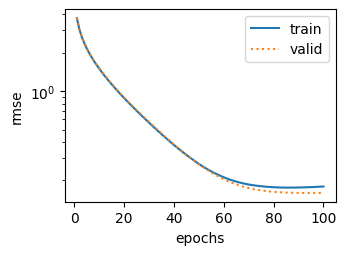

In [15]:
k = 5
num_epochs = 100
learning_rate = 5
weight_decay = 0.1
batch_size = 64

train_l, valid_l = k_fold(k, train_features, train_labels,
                          num_epochs, learning_rate, weight_decay, batch_size)
print('k-fold avg train rmse: %f, avg valid rmse: %f' % (train_l, valid_l))

In [16]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)


train rmse 0.177421


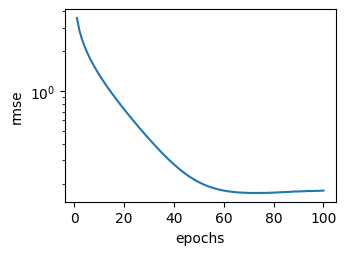

In [17]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, learning_rate, weight_decay, batch_size)


## 最终版本

In [19]:
# import torch
# import torch.nn as nn
# import numpy as np
# import pandas as pd
# import utils
#
# train_data = pd.read_csv(r'/kaggle/house_price/HousePrices\train.csv')
# test_data = pd.read_csv(r'/kaggle/house_price/HousePrices\test.csv')
#
# all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#
# numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# all_features[numeric_features] = all_features[numeric_features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# all_features[numeric_features] = all_features[numeric_features].fillna(0)
#
# all_features = pd.get_dummies(all_features, dummy_na=True)
#
# n_train = train_data.shape[0]
# train_features = torch.tensor(all_features[:n_train].to_numpy(dtype='float32'), dtype=torch.float)
# test_features = torch.tensor(all_features[n_train:].to_numpy(dtype='float32'), dtype=torch.float)
# train_labels = torch.tensor(train_data.SalePrice.to_numpy(), dtype=torch.float).view(-1, 1)
#
# loss = torch.nn.MSELoss()
#
#
# def get_net(feature_num):
#     net = nn.Linear(feature_num, 1)
#     for param in net.parameters():
#         nn.init.normal_(param, mean=0, std=0.01)
#     return net
#
#
# def log_rmse(net, features, labels):
#     with torch.no_grad():
#         clipped_preds = torch.max(net(features), torch.tensor(1.0))
#         rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
#     return rmse.item()
#
#
# def train(net, train_features, train_labels, test_features, test_labels,
#           num_epochs, learning_rate, weight_decay, batch_size):
#     train_ls, test_ls = [], []
#     dataset = torch.utils.data.TensorDataset(train_features, train_labels)
#     train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
#     optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     net = net.float()
#
#     for epoch in range(num_epochs):
#         for X, y in train_iter:
#             l = loss(net(X.float()), y.float())
#             optimizer.zero_grad()
#             l.backward()
#             optimizer.step()
#         train_ls.append(log_rmse(net, train_features, train_labels))
#         if test_labels is not None:
#             test_ls.append(log_rmse(net, test_features, test_labels))
#     return train_ls, test_ls
#
#
# def get_k_fold_data(k, i, X, y):
#     assert k > 1
#     fold_size = X.shape[0] // k
#     X_train, y_train = None, None
#
#     for j in range(k):
#         idx = slice(j * fold_size, (j + 1) * fold_size)
#         X_part, y_part = X[idx, :], y[idx]
#         if j == i:
#             X_valid, y_valid = X_part, y_part
#         elif X_train is None:
#             X_train, y_train = X_part, y_part
#         else:
#             X_train = torch.cat((X_train, X_part), dim=0)
#             y_train = torch.cat((y_train, y_part), dim=0)
#     return X_train, y_train, X_valid, y_valid
#
#
# def k_fold(k, X_train, y_train, num_epochs,
#            learning_rate, weight_decay, batch_size):
#     train_l_sum, valid_l_sum = 0, 0
#     for i in range(k):
#         data = get_k_fold_data(k, i, X_train, y_train)
#         net = get_net(X_train.shape[1])
#         train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
#                                    weight_decay, batch_size)
#         train_l_sum += train_ls[-1]
#         valid_l_sum += valid_ls[-1]
#
#         if i == 0:
#             utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
#                            range(1, num_epochs + 1), valid_ls,
#                            ['train', 'valid'])
#         print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
#
#     return train_l_sum / k, valid_l_sum / k
#
#
# k = 5
# num_epochs = 100
# learning_rate = 5
# weight_decay = 0.1
# batch_size = 64
#
# train_l, valid_l = k_fold(k, train_features, train_labels,
#                           num_epochs, learning_rate, weight_decay, batch_size)
# print('k-fold avg train rmse: %f, avg valid rmse: %f' % (train_l, valid_l))
#
#
# def train_and_pred(train_features, test_features, train_labels, test_data,
#                    num_epochs, lr, weight_decay, batch_size):
#     net = get_net(train_features.shape[1])
#     train_ls, _ = train(net, train_features, train_labels, None, None,
#                         num_epochs, lr, weight_decay, batch_size)
#     utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
#     print('train rmse %f' % train_ls[-1])
#     preds = net(test_features).detach().numpy()
#     test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
#     submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
#     submission.to_csv('./submission.csv', index=False)
#
#
# train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, learning_rate, weight_decay,
#                batch_size)
